In [1]:
%pip install pandas -q
%pip install torch -q
%pip install transformers -q
%pip install ipywidgets -q
%pip install --user -U nltk -q
%pip install datasets sacrebleu -q
%pip install evaluate -q
%pip install accelerate -U -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [2]:
import zipfile
import pandas as pd
import os

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initial data exploration

In [3]:
zip_file_path = '../data/raw/filtered_paranmt.zip'
extracted_dir = '../data/raw/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [4]:
tsv_file_name = 'filtered.tsv' 

# Construct the full path to the TSV file
tsv_file_path = os.path.join(extracted_dir, tsv_file_name)
print(f"Path to tsv file: {tsv_file_path}")

# Read the TSV file into a DataFrame
df = pd.read_csv(tsv_file_path, delimiter='\t')

df.head()


Path to tsv file: ../data/raw/filtered.tsv


,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


## Preprocesing

### Preprocessing - swap translation and reference

In [5]:
def swap_ref_trn(row):
    if row['ref_tox'] < row['trn_tox']:
        row['reference'], row['translation'] = row['translation'], row['reference']
        row['ref_tox'], row['trn_tox'] = row['trn_tox'], row['ref_tox']
    return row

def add_stat_columns(df):
    df['tox_diff'] = round(df['ref_tox'] - df['trn_tox'], 3)
    return df

def round_columns(df):
    df['similarity'] = round(df['similarity'], 2)
    df['lenght_diff'] = round(df['lenght_diff'], 2)
    return df

### 

### Main preprocessing function

In [6]:
def preprocess(df):
    df = df.apply(swap_ref_trn, axis=1)
    df = add_stat_columns(df)
    df = round_columns(df)
    return df

In [7]:
df_processed = preprocess(df)
df_processed.head()

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,tox_diff
0,0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t...",0.79,0.01,0.981983,0.014195,0.968
1,1,you're becoming disgusting.,Now you're getting nasty.,0.75,0.07,0.999039,0.065473,0.934
2,2,"well, we can spare your life.","Well, we could spare your life, for one.",0.92,0.27,0.985068,0.213313,0.772
3,3,"monkey, you have to wake up.","Ah! Monkey, you've got to snap out of it.",0.66,0.31,0.994215,0.053362,0.941
4,4,I have orders to kill her.,I've got orders to put her down.,0.73,0.18,0.999348,0.009402,0.990


### Maybe I should assign more weight to the high toxic and good paraphrased data points when training

In [106]:
df_sorted = df_processed.sort_values(by=['tox_diff', 'similarity', 'lenght_diff'], ascending=[False, False, True])
df_sorted.head()

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,tox_diff
85652,85652,"damn, Scotty.","Jeez, Scotty.",0.95,0.00,0.999598,0.000078,1.0
168565,168565,"damn, kid.","Jeez, kid.",0.95,0.00,0.999662,0.000143,1.0
100035,100035,"God Almighty shit, Leroy.","God Almighty, Leroy.",0.95,0.19,0.999614,0.000051,1.0
421001,421001,New Age fuckups.,postmen from New Age.,0.95,0.23,0.999621,0.000052,1.0
543755,543755,Fucking the prom queen.,the prom queen.,0.95,0.33,0.999664,0.000078,1.0


# Visualization

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


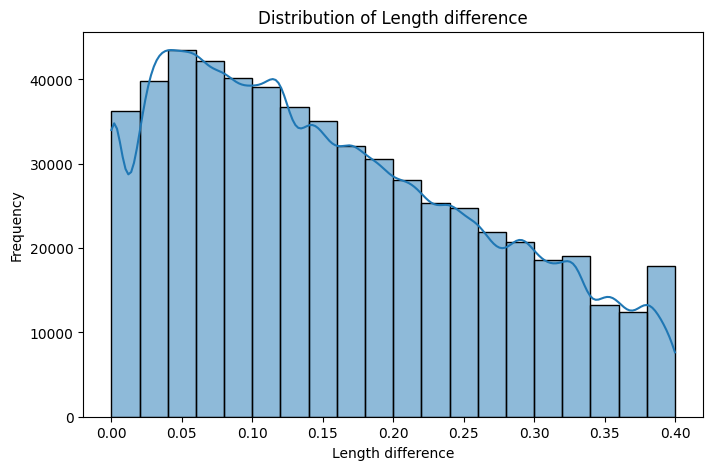

In [66]:
plt.figure(figsize=(8, 5))
sns.histplot(df_sorted['lenght_diff'], bins=20, kde=True)
plt.xlabel('Length difference')
plt.ylabel('Frequency')
plt.title('Distribution of Length difference')
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


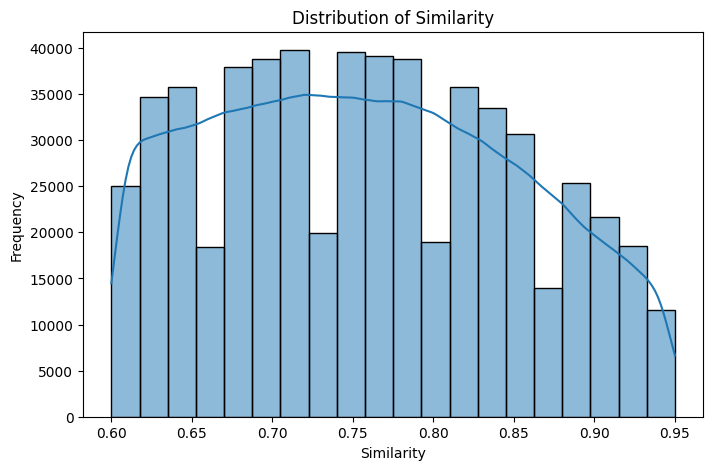

In [68]:
plt.figure(figsize=(8, 5))
sns.histplot(df_sorted['similarity'], bins=20, kde=True)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity')
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


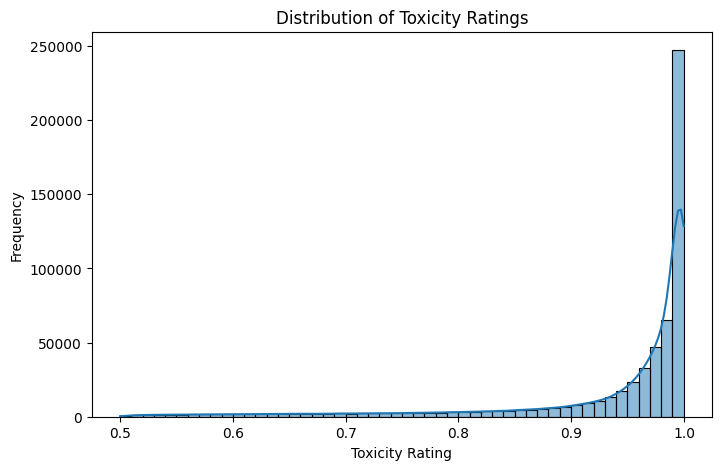

In [36]:
# Visualize distribution of Toxicity Ratings
plt.figure(figsize=(8, 5))
sns.histplot(df_sorted['ref_tox'], bins=50, kde=True)
plt.xlabel('Toxicity Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Toxicity Ratings')
plt.show()

# Data preprocessing - basic ideas

### Common preprocessing steps:
1. Lowercasting
1. Removing punctuation
1. Removing numbers
1. Stemming and lemmatization
1. Tokenization

In [11]:
def lower_text(text: str):
    return text.lower()

def remove_numbers(text: str):
    without_numbers = re.sub(r'\d+', ' ', text)
    return without_numbers

def remove_punctuation(text: str):
    without_punctuation = re.sub(r'[^a-z|\s]+', ' ', text)
    return without_punctuation

def remove_multiple_spaces(text: str):
    without_doublespace = re.sub('\s+', ' ', text).strip()
    return without_doublespace

nltk.download('stopwords')
nltk.download('punkt')
stopwords_set = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def tokenize_text(text: str):
    return word_tokenize(text)

def remove_stop_words(tokenized_text: list[str]):
    return [
        w for w in tokenized_text
        if w not in stopwords_set
    ]

def stem_words(tokenized_text: list[str]):
    return [
        ps.stem(w)
        for w in tokenized_text
    ]

def clean_data(sentence):
    _lowered = lower_text(sentence)
    _without_numbers = remove_numbers(_lowered)
    _without_punct = remove_punctuation(_without_numbers)
    _single_spaced = remove_multiple_spaces(_without_punct)
    _tokenized = tokenize_text(_single_spaced)
    _without_sw = remove_stop_words(_tokenized)
    _stemmed = stem_words(_without_sw)
    return _stemmed
    
def clean_dataframe(df, filename='cleaned.csv', dir='../data/interim/', override=False):
    file = os.path.join(dir, filename)

    # Check cache
    if (os.path.exists(file) and not override):
        return pd.read_csv(file)
    
    df['reference'] = df['reference'].apply(lambda s: clean_data(s))
    df['translation'] = df['translation'].apply(lambda s: clean_data(s))

    # Cache version
    df.to_csv(file, index=False)

    return df


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
df_cleaned = clean_dataframe(df_processed, override=True)
df_cleaned.head()

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox,tox_diff,length_diff
0,0,"[alkar, flood, mental, wast, would, explain, h...","[alkar, flood, psychic, wast, explain, high, l...",0.79,0.010309,0.981983,0.014195,0.968,0.01
1,1,"[becom, disgust]","[get, nasti]",0.75,0.071429,0.999039,0.065473,0.934,0.07
2,2,"[well, spare, life]","[well, could, spare, life, one]",0.92,0.268293,0.985068,0.213313,0.772,0.27
3,3,"[monkey, wake]","[ah, monkey, got, snap]",0.66,0.309524,0.994215,0.053362,0.941,0.31
4,4,"[order, kill]","[got, order, put]",0.73,0.181818,0.999348,0.009402,0.990,0.18


### Check what words were removed after paraphrasing

In [ ]:
from collections import Counter
import ast
counter = Counter()

for i in df_cleaned.iterrows():
    ref = i[1]['reference']
    trn = i[1]['translation']

    if not isinstance(ref, list):    
        ref = ast.literal_eval(ref)

    if not isinstance(ref, list):    
        trn = ast.literal_eval(trn)
    
    
    for r in ref:
        if (r not in trn): 
            counter[r] += 1

    

In [1]:
'fuck' in counter, 'idiot' in counter

NameError: name 'counter' is not defined

In [146]:
import numpy as np
import torch
import torch.nn.functional as nn
# counter.keys(), 
inp = torch.tensor(list(counter.values()), dtype=torch.float)
probs = inp / inp.max()

percent = 0.15

z = zip(counter.keys(), probs)
for i, j in enumerate(z):
    
    if ( j[1] > percent): print(j)

('kill', tensor(0.2149))
('gon', tensor(0.2484))
('na', tensor(0.2793))
('ass', tensor(0.2120))
('go', tensor(0.2452))
('shit', tensor(0.5674))
('like', tensor(0.2144))
('fuck', tensor(1.))
('got', tensor(0.1766))
('damn', tensor(0.4085))
('get', tensor(0.2468))
('hell', tensor(0.2663))
('stupid', tensor(0.1612))


# Evalution
## Methods
1. BLUE score
1. Perplexity
1. BERT assesment
1. Other nlp assesment


# Test

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = "gpt2"  # You can use other model names like "gpt2-medium" or "gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-30 12:37:02.770132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-30 12:37:02.770185: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-30 12:37:02.775373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-30 12:37:03.817451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow

In [179]:
train_texts = [
    {"toxic": "You're such an idiot!", "rephrased": "I disagree with you."},
    {"toxic": "This is terrible!", "rephrased": "This is not ideal."},
    # Add more pairs as needed
]

tokenizer.pad_token = tokenizer.eos_token
def tok(sent):
    return tokenizer(sent, padding='max_length', truncation=True, max_length=10, return_tensors="pt")

tok(train_texts[0]['toxic']), tok(train_texts[0]['rephrased'])

({'input_ids': tensor([[ 1639,   821,   884,   281, 22324, 21551,     0, 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])},
 {'input_ids': tensor([[   40, 12546,   351,   345,    13, 50256, 50256, 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])})

In [11]:
prompt = "What is the synonim to the word fuck? Tell only one word as our output"
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate text
output = model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2, top_k=50)

# Decode and print the generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True, tempreture=0)

print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


What is the synonim to the word fuck? Tell only one word as our output.

The synonym for fuck is a word that is used to describe a sexual act. It is often used in the context of a relationship, but


# Methods
1. Select toxic words or parts and then paraphrase them
1. Translate into French as the most similar to English and then back to English


identify toxic words and replace them with non-toxic synonyms.
since Such markers (i) carry most of stylistic information of a sentence(i.e.their presence is a strong indicator of this class),(ii) have synonyms which are free from this stylistic information.
need to somehow identify what words are toxic in the current dataset

# Test T5 as a translation from toxic to neutral

In [24]:
from datasets import load_metric, Dataset
model_checkpoint = "t5-small"
metric = load_metric("sacrebleu")

In [22]:
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq,  Seq2SeqTrainer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

2023-10-01 09:33:08.631043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-01 09:33:08.631096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-01 09:33:08.634980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-01 09:33:09.595260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def find_max_sentence_length(sentences):
    m = 0
    sent = 0
    for s in sentences:
        if (m < len(s)):
            m = len(s)
            sent = s
        
    return m, sent

In [8]:
find_max_sentence_length(df_processed['reference'])

NameError: name 'df_processed' is not defined

In [26]:
max_input_length = 128
max_target_length = 128
source_type = 'reference'
target_type = 'translation'

prefix = "paraphrase from toxic to neutral:"

dataset_dict = {
    "reference": df["reference"].tolist(),
    "translation": df["translation"].tolist()
}
dataset = Dataset.from_dict(dataset_dict)
dataset

Dataset({
    features: ['reference', 'translation'],
    num_rows: 577777
})

In [27]:
def preprocess_function(examples):
    print(examples)
    inputs = [prefix + ex for ex in examples[source_type]]
    targets = list(examples[target_type])
    
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets[0]

In [23]:
tokenized_datasets = preprocess_function(df_processed.iloc[:1])
tokenized_datasets


{'input_ids': [[3856, 27111, 45, 12068, 12, 7163, 10, 99, 901, 4031, 8347, 7, 160, 28, 160, 2550, 2670, 6, 34, 133, 3209, 8, 306, 1425, 13, 6567, 7031, 1538, 449, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[156, 901, 4031, 19, 18368, 160, 28, 26829, 2670, 6, 24, 3, 9453, 8, 306, 593, 13, 6567, 7031, 1538, 4849, 5, 1]]}

In [ ]:
# defining the parameters for training
batch_size = 32
model_name = model_checkpoint.split("/")[-1]
print(model_name)
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
    report_to='tensorboard',
)

# New

In [51]:
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import numpy as np

checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

prefix = "paraphrase from toxic to neutral: "

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)
metric = evaluate.load("sacrebleu")

training_args = Seq2SeqTrainingArguments(
    output_dir="output_dir",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    # fp16=True,
    report_to='tensorboard',
)

In [52]:
def preprocess_function(examples):
    inputs = [prefix + example for example in examples["reference"]]
    targets = examples["translation"]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [107]:
train_dataset = Dataset.from_pandas(df_sorted[['reference', 'translation']].iloc[:1000]).map(preprocess_function, batched=True)
val_dataset = Dataset.from_pandas(df_sorted[['reference', 'translation']].iloc[1000:1100]).map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
val_dataset[0]

In [111]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [112]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,1.323574,40.312100,10.720000
2,No log,1.317676,40.765400,10.320000
3,No log,1.310212,42.071300,10.310000
4,No log,1.304846,42.412800,10.260000
5,No log,1.298181,42.536300,10.270000
6,No log,1.294548,43.163600,10.290000
7,No log,1.291904,43.163600,10.290000
8,1.038100,1.288283,43.163600,10.290000
9,1.038100,1.287698,43.163600,10.290000
10,1.038100,1.288008,43.163600,10.290000


TrainOutput(global_step=630, training_loss=1.0219200376480344, metrics={'train_runtime': 754.989, 'train_samples_per_second': 13.245, 'train_steps_per_second': 0.834, 'total_flos': 81012641759232.0, 'train_loss': 1.0219200376480344, 'epoch': 10.0})

In [113]:
trainer.save_model("output_dir")

In [279]:
text = prefix + "where did this shit come from, Is it from this stupid person?"
checkp = 'output_dir'
# checkp = checkpoint
tokenizer = AutoTokenizer.from_pretrained(checkp)
inputs = tokenizer(text, return_tensors="pt").input_ids

model = AutoModelForSeq2SeqLM.from_pretrained(checkp)

In [280]:
outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)

tokenizer.decode(outputs[0], skip_special_tokens=True)

'where did this come from, is it from this person?'